In [1]:
# Built-in imports
import sys
from pathlib import Path

# External imports
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mrcnn.model import MaskRCNN
from mrcnn import visualize

# Local imports
from train import run_length_encoded_to_mask
from config import ROOT_DIR
from config import DEFECTS
from config import TRAIN_IMAGES_DIR
from config import MODEL_DIR
from config import CLASS_NAMES
from config import InferenceConfig

In [2]:
if not ROOT_DIR.exists():
    sys.exit("Root dir doesn't exist, quitting.")

train = pd.read_csv(ROOT_DIR / 'train.csv')
train_images_dir = ROOT_DIR / 'train_images'

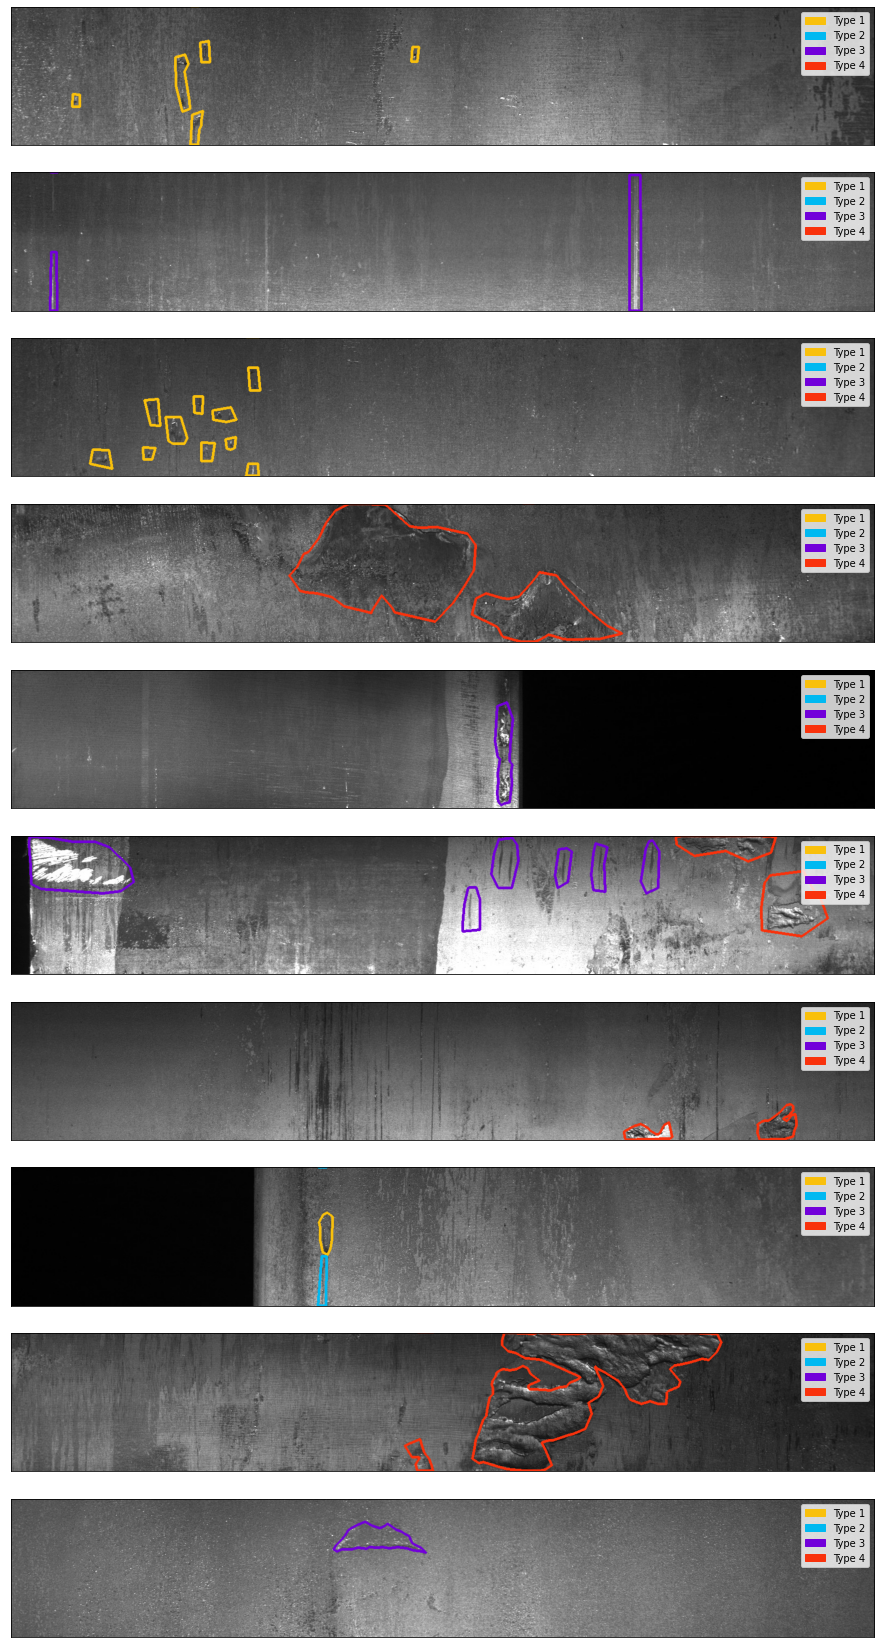

In [3]:
legend_elements = [
    Patch(
        facecolor = np.array(d['color']) / 255, 
        edgecolor = np.array(d['color']) / 255,
        label     = d['name']
    ) for d in DEFECTS ]

NUM_SAMPLES = 10
groups = list(train.groupby('ImageId'))[:NUM_SAMPLES]

fig,axs = plt.subplots(NUM_SAMPLES, 1, figsize=(30,30))
for i, (im_name,group) in enumerate(groups):
    im_path = str(train_images_dir/im_name)
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    for _,row in group.iterrows():
        color = row['ClassId'] - 1
        mask = run_length_encoded_to_mask(row['EncodedPixels'], im.shape[0], im.shape[1])
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(im, contours, -1, DEFECTS[color]['color'], 3)
    
    axs[i].imshow(im)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend(handles=legend_elements)

In [4]:
###############################################################################
# Detection setup
###############################################################################

steel_config = InferenceConfig()

model = MaskRCNN(
    mode      = "inference",
    config    = steel_config,
    model_dir = str(MODEL_DIR)
)

Instructions for updating:
Use fn_output_signature instead


Processing 1 images
image                    shape: (256, 1600, 3)        min:    0.00000  max:  169.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   62.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
1 results.


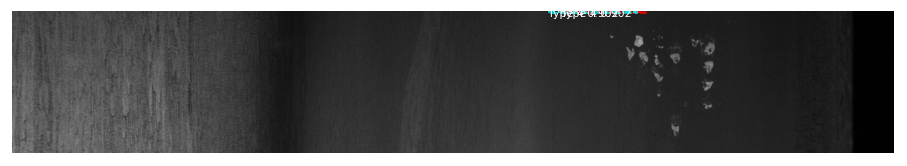

In [26]:
im_path = str(np.random.choice(list(TRAIN_IMAGES_DIR.iterdir())))
original_im = cv2.imread(im_path)
original_im = cv2.cvtColor(original_im, cv2.COLOR_BGR2RGB)
im          = original_im.copy()

# Run the detection pipeline
# images: List of images, potentially of different sizes.
# Returns a list of dicts, one dict per image. The dict contains:
#     rois      : [N, (y1, x1, y2, x2)] detection bounding boxes
#     class_ids : [N] int class IDs
#     scores    : [N] float probability scores for the class IDs
#     masks     : [H, W, N] instance binary masks
results = model.detect(images=[im], verbose=1)
r = results[0]

print(f"{len(results)} results.")

###############################################################################
# Visualization 
###############################################################################

visualize.display_instances(
    image       = im,
    boxes       = r['rois'],
    masks       = r['masks'],
    class_ids   = r['class_ids'], 
    scores      = r['scores'],
    class_names = CLASS_NAMES
)